In [178]:
%matplotlib inline
import uproot3 as uproot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
from IPython.display import display



In [179]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [180]:
import pandas as pd


""" data_dict = {
    "raw_jet_pt": tree.array("raw_jet_pt"),
    "raw_jet_eta": tree.array("raw_jet_eta"),
    "raw_jet_phi": tree.array("raw_jet_phi"),
    "raw_jet_mass": tree.array("raw_jet_mass"),
    "raw_jet_charge": tree.array("raw_jet_charge"),
    #"raw_jet_meanSquareDeltaR": tree.array("raw_jet_meanSquareDeltaR"),
    "raw_jet_nneutrals": tree.array("raw_jet_nneutrals"),
    "raw_jet_ncharged": tree.array("raw_jet_ncharged"),
    "raw_jet_EhadOverEem": tree.array("raw_jet_EhadOverEem"),

    #"raw_jet_tau3": tree.array("raw_jet_tau3"),
    #"raw_jet_tau1": tree.array("raw_jet_tau1"),
    #"raw_jet_tau5": tree.array("raw_jet_tau5"),
    #"raw_jet_tau2": tree.array("raw_jet_tau2"),
    #"raw_jet_tau4": tree.array("raw_jet_tau4"),

    "gen_jet_pt": tree.array("gen_jet_pt")  # Assuming "gen_jet_pt" is your target variable
} """


# The branches that are currently not in use -> "raw_jet_meanSquareDeltaR" and all "raw_jet_tau"

df = pd.read_csv("combined_jet_data.csv") # -> Combined Dataframe with all the bins

features = df[[arr for arr in df if arr != "gen_jet_pt"]]
target = df["gen_jet_pt"]

features = features.apply(pd.to_numeric, errors='coerce')
target = target.apply(pd.to_numeric, errors='coerce')


print(features)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


          raw_jet_pt  raw_jet_eta  raw_jet_phi  raw_jet_mass  raw_jet_charge  \
0          35.132942     1.419450     1.806104      8.650763               0   
1          21.769182    -1.915459    -1.139416      3.026642              -1   
2          42.598263    -0.570198    -2.637006     12.773981               1   
3          36.408432    -1.451989     0.856676      6.659202              -4   
4          27.832796    -1.959888     1.523597      7.630062              -4   
...              ...          ...          ...           ...             ...   
1081400  2136.343500    -0.050339    -2.771411    174.719500               0   
1081401  2055.546600    -0.819397     1.774915    120.706610               1   
1081402  2754.469200     0.607942    -1.716554    160.097980              -4   
1081403  2592.159000     0.181301     1.454840     85.955180               5   
1081404  2083.743200     0.072322     0.872120     65.440350              -2   

         raw_jet_nneutrals  raw_jet_nch

In [181]:
print(target)

0            37.464607
1            23.263933
2            46.712750
3            40.084610
4            30.752882
              ...     
1081400    2274.236800
1081401    1954.995200
1081402    2757.110800
1081403    2795.318600
1081404    2035.805200
Name: gen_jet_pt, Length: 1081405, dtype: float64


In [182]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, features_scaled, target):
        self.features_scaled = torch.tensor(features_scaled, dtype=torch.float32)
        self.target = torch.tensor(target.to_numpy(), dtype=torch.float32)

    def __len__(self):
        return len(self.features_scaled)

    def __getitem__(self, idx):
        return self.features_scaled[idx], self.target[idx]



In [183]:

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features_scaled, target, test_size=0.4, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


array([[ 0.84914147, -0.20813003,  0.39261944, ...,  0.16316924,
         1.16537034, -0.15728288],
       [-0.59770854,  0.93413536,  0.63050967, ...,  0.49690256,
        -0.19080228, -0.15700424],
       [ 0.91683923, -0.03676612, -0.1340064 , ...,  2.94428021,
         1.50441349, -0.15614217],
       ...,
       [ 0.39883285, -0.74247287,  1.13038115, ...,  0.38565812,
        -0.27556307, -0.15941865],
       [-0.42337246,  0.93805885,  0.27620856, ..., -0.72678627,
        -0.69936702, -0.13728232],
       [-0.83147823,  0.07180697, -1.28943132, ..., -0.83803071,
        -0.69936702, -0.14544975]])

1081405
1081405


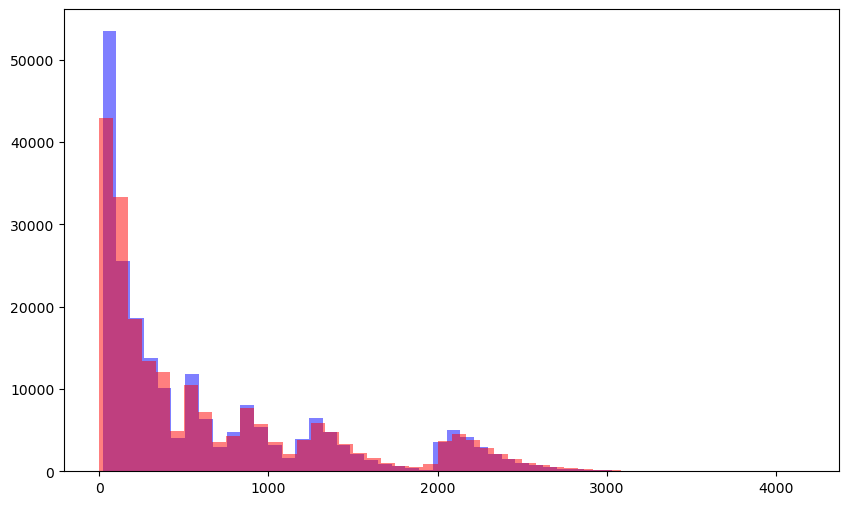

In [184]:
plt.figure(figsize=(10, 6))
x_test_orig = scaler.inverse_transform(X_test)
# Plot the histogram for raw_jet_pt
plt.hist(x_test_orig[:,0], bins=50, label='raw_jet_pt', alpha=0.5, color='blue')

# Plot the histogram for predicted corrected jet pt
plt.hist(y_test, bins=50, label='gen_jet_pt', alpha=0.5, color='red')

In [185]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class MyModel(nn.Module):
    def __init__(self, input_dim, l1_reg, l2_reg):
        super(MyModel, self).__init__()
        
        node_size = 512
        
        self.layer1 = nn.Linear(input_dim, node_size)
        self.layer2 = nn.Linear(node_size, node_size)
        self.layer3 = nn.Linear(node_size, node_size)  
        self.layer4 = nn.Linear(node_size, node_size)
        self.layer5 = nn.Linear(node_size, node_size) 
        self.layer6 = nn.Linear(node_size, node_size) 
        self.layer7 = nn.Linear(node_size, node_size)
        self.layer8 = nn.Linear(node_size, node_size)
        self.layer9 = nn.Linear(node_size, 1) # Output layer with a single unit for regression
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg

    def forward(self, x):
        x = F.relu(self.layer1(x))  # ReLU activation
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
        x = F.relu(self.layer6(x))
        x = F.relu(self.layer7(x))
        x = F.relu(self.layer8(x))
        output = self.layer9(x)
        return output


l1_reg = 0.01 # Strength of L1 regularization
l2_reg = 0.01 # Strength of L2 regularization


def MAPE(y_pred, y_train): # Mean Absolute Percentage Error
    percentage_difference = torch.abs((y_pred - y_train) / y_train)
    return torch.mean(percentage_difference)


def mse_with_regularization(y_pred, y_true, model):
    y_true = y_true.view(y_pred.shape)  # Reshape y_true to match y_pred shape
    loss = F.mse_loss(y_pred, y_true)  # Mean Square Error (MSE) loss
    l1_loss = torch.tensor(0.0, requires_grad=True)
    for param in model.parameters():
        l1_loss = l1_loss + torch.norm(param, p=1)  # L1 regularization term
    total_loss = loss + model.l1_reg * l1_loss  # Include L1 regularization in the total loss
    return total_loss


def mape_with_regularization(y_pred, y_true, model):
    loss = MAPE(y_pred, y_true)
    l1_loss = torch.tensor(0.0, requires_grad=True)
    for param in model.parameters():
        l1_loss = l1_loss + torch.norm(param, p=1)  # L1 regularization term
    total_loss = loss + model.l1_reg * l1_loss
    return total_loss





model = MyModel(X_train.shape[1], l1_reg, l2_reg)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_reg)  # L2 regularization (Ridge)



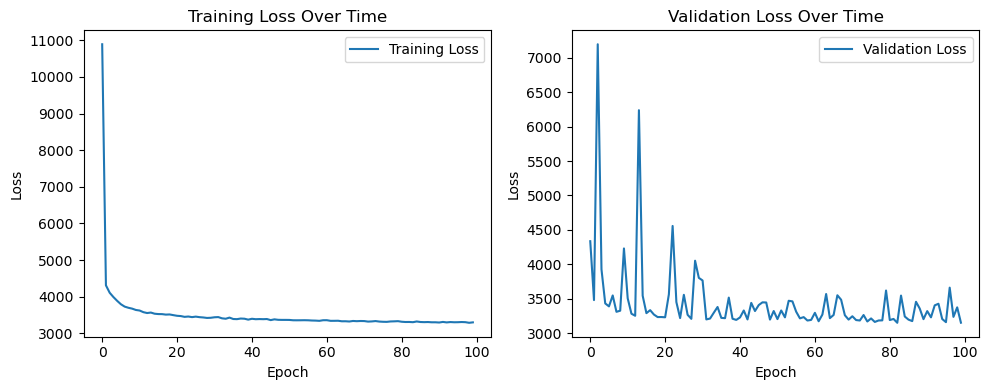

100%|██████████| 100/100 [56:57<00:00, 34.18s/it]


In [186]:
import tqdm
from sklearn.metrics import r2_score
from IPython.display import clear_output

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
validation_dataset = CustomDataset(X_validation, y_validation)


# Create DataLoader objects
batch_size = 256  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)


# Training loop
EPOCHS = 100
loss_list = np.zeros((EPOCHS,))
r2_list = np.zeros((EPOCHS,))
val_loss_list = np.zeros((EPOCHS,))
val_r2_list = np.zeros((EPOCHS,))


# Create empty lists to store loss values for training and validation plotting
train_loss_history = []
val_loss_history = []


for epoch in tqdm.trange(EPOCHS):
    
    # Training phase
    model.train()  # Set the model to training mode
    for inputs, targets in train_loader:
        y_pred = model(inputs)
        loss = mse_with_regularization(y_pred, targets, model)
        loss_list[epoch] += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate R-squared for the current training batch
        r2_batch = r2_score(targets.cpu().numpy(), y_pred.cpu().detach().numpy())
        r2_list[epoch] += r2_batch

    
    # Compute the training loss for the epoch
    loss_list[epoch] /= len(train_loader)
    r2_list[epoch] /= len(train_loader)

    
    
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_loss = 0.0
        y_true_val = []
        y_pred_val = []
        for inputs, targets in validation_loader:
            y_pred = model(inputs)
            val_loss += mse_with_regularization(y_pred, targets, model).item()
            y_true_val.extend(targets.cpu().numpy())
            y_pred_val.extend(y_pred.cpu().numpy())

        # Compute the validation loss for the epoch
        val_loss /= len(validation_loader)

        # Calculate R-squared for validation
        r2_val = r2_score(y_true_val, y_pred_val)


        # Store the validation loss and R-squared values
        val_loss_list[epoch] = val_loss
        val_r2_list[epoch] = r2_val

    
    
    # Append the loss values to the history lists
    train_loss_history.append(loss_list[epoch])
    val_loss_history.append(val_loss_list[epoch])

     # Update and display the dynamic loss plot
    clear_output(wait=True)

    plt.figure(figsize=(10, 4))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(range(epoch + 1), train_loss_history, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.legend()

    # Plot validation loss
    plt.subplot(1, 2, 2)
    plt.plot(range(epoch + 1), val_loss_history, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Validation Loss Over Time")
    plt.legend()

    plt.tight_layout()
    plt.show()







    

In [187]:
# Testing loop
test_loss = 0.0
y_true_test = []
y_pred_test = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, targets in test_loader:
        y_pred = model(inputs)
        test_loss += mse_with_regularization(y_pred, targets, model).item()
        y_true_test.extend(targets.cpu().numpy())
        y_pred_test.extend(y_pred.cpu().numpy())

# Compute the test loss
test_loss /= len(test_loader)


# Calculate R-squared for the test set
r2_test = r2_score(y_true_test, y_pred_test)

# Print or store the test loss and R-squared
print(f"Test Loss: {test_loss}")
print(f"Test R-squared: {r2_test}")


Test Loss: 3161.4603710648576
Test R-squared: 0.9937874802244078


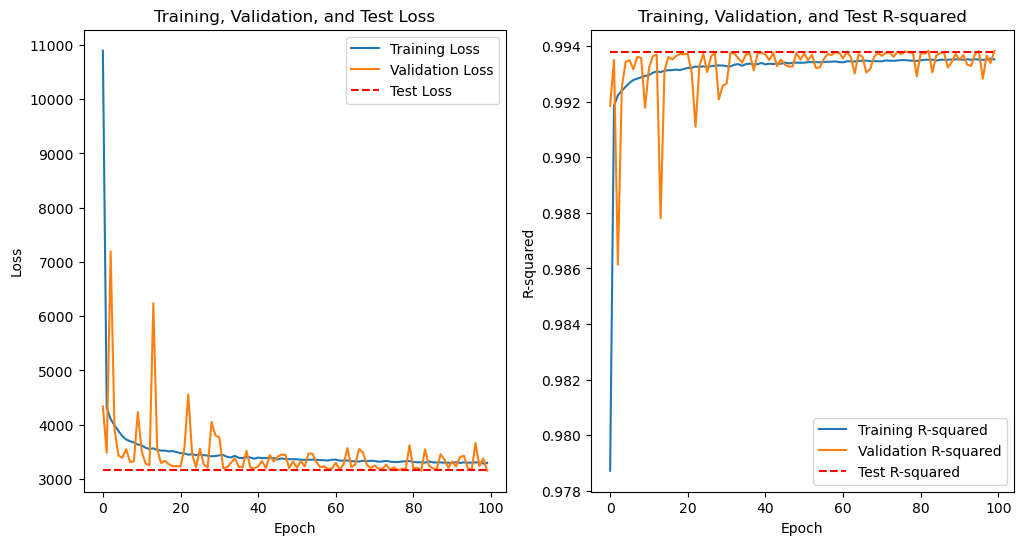

In [188]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), loss_list, label='Training Loss')
plt.plot(range(EPOCHS), val_loss_list, label='Validation Loss')
plt.plot(range(EPOCHS), [test_loss] * EPOCHS, label='Test Loss', linestyle='--', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training, Validation, and Test Loss')

# Plot the training and validation R-squared
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), r2_list, label='Training R-squared')
plt.plot(range(EPOCHS), val_r2_list, label='Validation R-squared')
plt.plot(range(EPOCHS), [r2_test] * EPOCHS, label='Test R-squared', linestyle='--', color='red')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.legend()
plt.title('Training, Validation, and Test R-squared')

plt.show()


216281
216281
216281
[[1269.3525  ]
 [ 220.04137 ]
 [1318.3088  ]
 ...
 [ 926.3459  ]
 [ 341.25836 ]
 [  52.038734]]
[1269.3525    220.04137  1318.3088   ...  926.3459    341.25836
   52.038734]


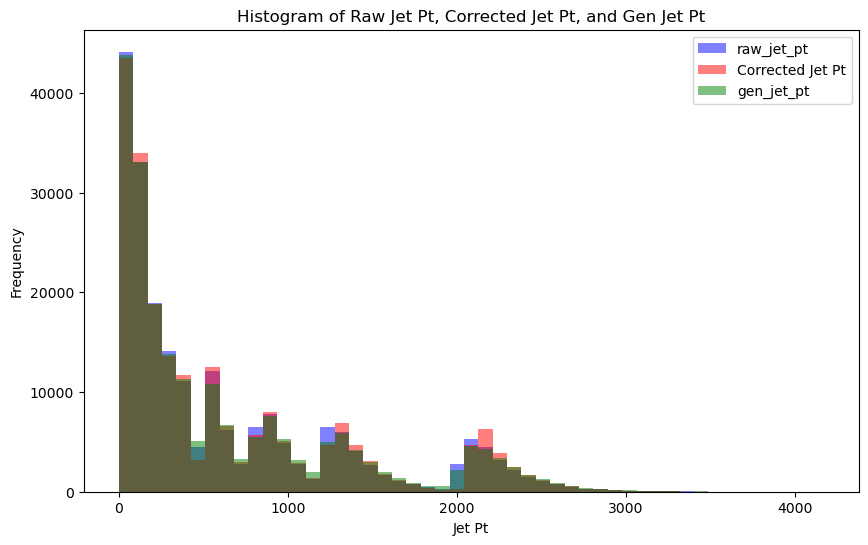

In [189]:
import matplotlib.pyplot as plt

# Step 1: Use your trained model to predict corrected jet pt
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Make predictions on your test data
    y_pred = model(torch.tensor(X_test, dtype=torch.float32))
    y_pred = y_pred.cpu().numpy()  # Convert predictions to NumPy array

# Step 2: Reverse transform the scaled features to their original scale
X_test_original_scale = scaler.inverse_transform(X_test)

print(len(y_pred))
print(len(X_test_original_scale[:, 0]))
print(len(y_test))
print(y_pred)
print(y_pred[:,0])
# Step 3: Create the histogram
plt.figure(figsize=(10, 6))

common_bin_edges = np.linspace(min(X_test_original_scale[:, 0].min(), y_pred.min(), y_test.min()),
                               max(X_test_original_scale[:, 0].max(), y_pred.max(), y_test.max()), 50)
# Plot the histogram for raw_jet_pt
plt.hist(X_test_original_scale[:, 0], bins=common_bin_edges, label='raw_jet_pt', alpha=0.5, color='blue')

# Plot the histogram for predicted corrected jet pt
plt.hist(y_pred, bins=common_bin_edges, label='Corrected Jet Pt', alpha=0.5, color='red')

# Plot the histogram for gen_jet_pt
plt.hist(y_test, bins=common_bin_edges, label='gen_jet_pt', alpha=0.5, color='green')





plt.xlabel('Jet Pt')
plt.ylabel('Frequency')
plt.title('Histogram of Raw Jet Pt, Corrected Jet Pt, and Gen Jet Pt')
plt.legend()
plt.show()


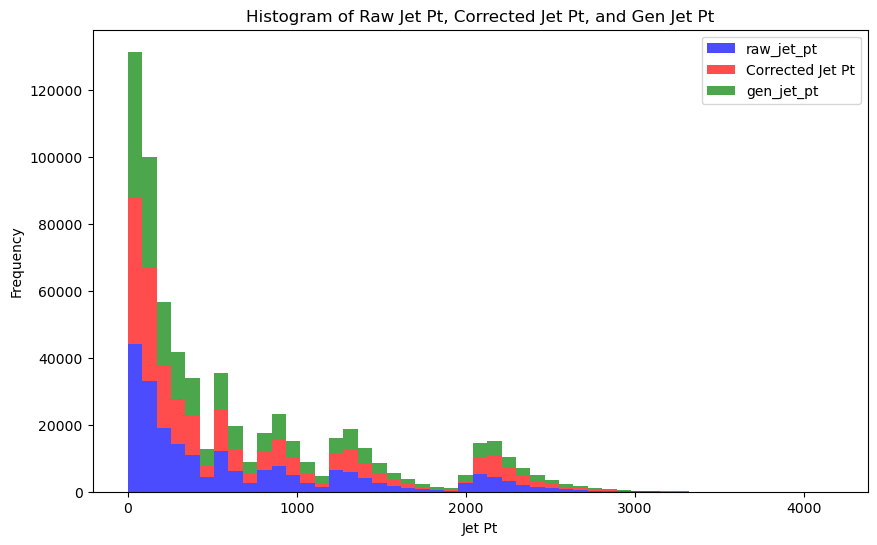

In [190]:
plt.figure(figsize=(10, 6))

common_bin_edges = np.linspace(min(X_test_original_scale[:, 0].min(), y_pred.min(), y_test.min()),
                               max(X_test_original_scale[:, 0].max(), y_pred.max(), y_test.max()), 50)

plt.hist([X_test_original_scale[:, 0], y_pred[:, 0], y_test], bins=common_bin_edges, label=['raw_jet_pt', 'Corrected Jet Pt', 'gen_jet_pt'], alpha=0.7, color=['blue', 'red', 'green'], stacked=True)

plt.xlabel('Jet Pt')
plt.ylabel('Frequency')
plt.title('Histogram of Raw Jet Pt, Corrected Jet Pt, and Gen Jet Pt')
plt.legend()
plt.show()

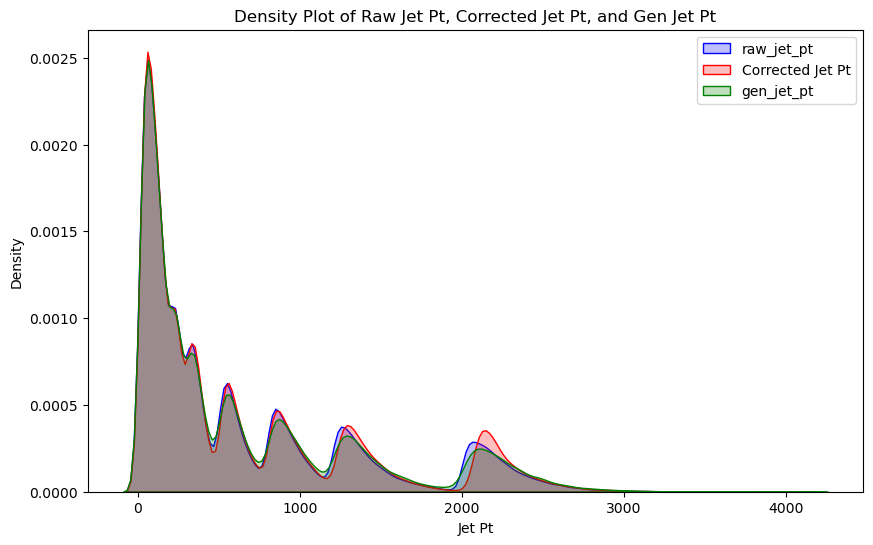

[1235.9614    220.58307  1283.4707   ...  919.94135   342.9296
   56.526897]


In [191]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Create a common set of bins
common_bins = np.linspace(min(X_test_original_scale[:, 0].min(), y_pred.min(), y_test.min()),
                         max(X_test_original_scale[:, 0].max(), y_pred.max(), y_test.max()), 100)

# Plot the KDE estimates using common bins
sns.kdeplot(X_test_original_scale[:, 0], label='raw_jet_pt', color='blue', fill=True, common_norm=False, common_grid=True, bw_adjust=0.5)
sns.kdeplot(y_pred[:,0], label='Corrected Jet Pt', color='red', fill=True, common_norm=False, common_grid=True, bw_adjust=0.5)
sns.kdeplot(y_test, label='gen_jet_pt', color='green', fill=True, common_norm=False, common_grid=True, bw_adjust=0.5)

plt.xlabel('Jet Pt')
plt.ylabel('Density')
plt.title('Density Plot of Raw Jet Pt, Corrected Jet Pt, and Gen Jet Pt')
plt.legend()
plt.show()

print(X_test_original_scale[:,0])


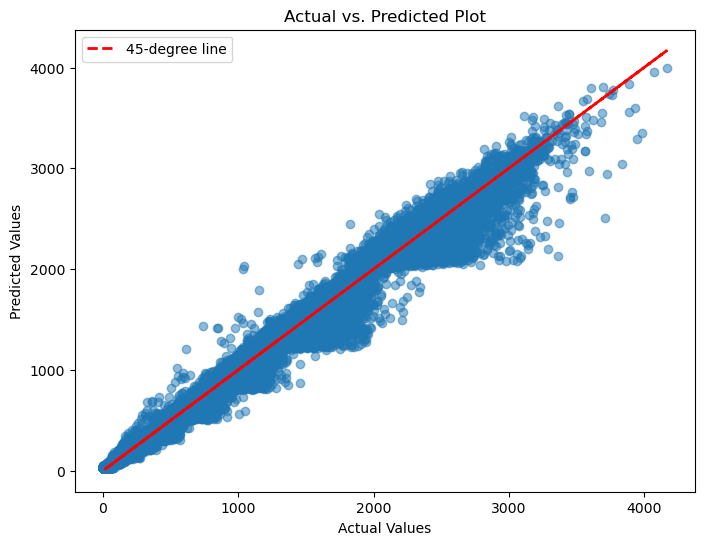

In [193]:
# Assuming you have already trained your model and have predictions
y_true = y_test  # Actual values from your test set
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Convert X_test DataFrame to a PyTorch Tensor
y_pred = model(X_test_tensor).detach().numpy()  # Predicted values converted to NumPy

# Inverse transform the scaled features
X_test_original_scale = scaler.inverse_transform(X_test)


# Create an Actual vs. Predicted scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

# If you want to plot a 45-degree line for reference
plt.plot(y_true, y_true, color='red', linestyle='--', linewidth=2, label="45-degree line")

plt.title("Actual vs. Predicted Plot")
plt.legend()
plt.show()





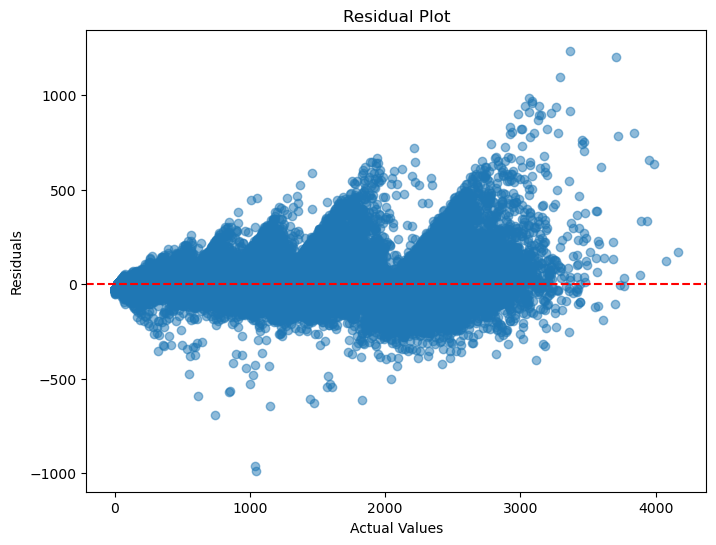

In [194]:
# Assuming you have already trained your model and have predictions
y_true = y_test.to_numpy()  # Convert y_test (DataFrame/Series) to a NumPy array
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Convert X_test DataFrame to a PyTorch Tensor
y_pred = model(X_test_tensor).detach().numpy()  # Predicted values converted to NumPy
y_pred_trans = np.transpose(y_pred)
# Calculate residuals
residuals = y_true - y_pred_trans

# Create a residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_true, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1.5)
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

